In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
from astropy.table import Table, Column
import time
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import sys
from scipy.stats import gaussian_kde
from tqdm import tqdm          
sys.path.insert(0, '../Modules')
import erqMedSpec
import erqScaling
import os
from matplotlib import cm
from  sklearn.neighbors import KernelDensity
# from scipy.stats import gaussian_kde
import matplotlib.ticker as ticker
from matplotlib import cm
from sklearn.model_selection import train_test_split

In [2]:
#  Readin/loading data
smp=Table.read('../LumMatch/LumMatch.fits')
iW3_0 = smp['i-w3']
kt80_0= smp['kurt80_gf']
rew_0 = smp['rew_gf']
rew_0  = np.log10(rew_0)
frat_0 = smp['frat_nv/civ']
fwhm_0 = smp['fwhm_gf']
# iz_0 = smp['i-z']
data_0=np.array(list(zip(iW3_0, rew_0)))
(data, minData, rangeData) =  erqScaling.MinMaxScaler(data_0)
# data= data_0
x0, y0= np.median(data, axis=0)
x,y= data.T
ERQ = data[((iW3_0>=4.6) & (rew_0>=2))]
x_erq, y_erq= np.median(ERQ, axis=0)  #center of ERQ population 
r_erq = np.sqrt((x_erq-x0)**2 + (y_erq-y0)**2)  # ERQ radius 
r_start = np.sqrt(((4.6-minData[0])/rangeData[0]-x0)**2 + ((2-minData[1])/rangeData[1]-y0)**2)  # ERQ radius 
print(r_start)

0.34919769808083606


In [3]:
#  Density Map -> 2D
enclosing_ratio=0.85; resolution=1000; ngrid=500; 
opening_angle, Wedge_direction = erqMedSpec.opening_angle_finder(ERQ, [x0,y0], enclosing_ratio, resolution)
print(np.rad2deg(opening_angle))

9.391457742389678


In [6]:
kde =gaussian_kde(data.T)
bw = kde.factor

# # Contour plot
x, y = data.T
xi, yi = np.mgrid[x.min():x.max():ngrid*1j, y.min():y.max():ngrid*1j]

# ERQ wedge 
nCone=1000; ex=1.3
d_theta= opening_angle
theta_cone = np.linspace(Wedge_direction-d_theta, Wedge_direction+d_theta, nCone)
rf= r_erq*ex
xf_cone = rf*np.cos(theta_cone) + x0
yf_cone= rf*np.sin(theta_cone) + y0

# dendity 
zi = kde(np.vstack([xi.flatten(), yi.flatten()]))
# mask = zi >0.015*max(zi)
# zi[mask]='nan'

<ipython-input-35-2dabef05519f>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


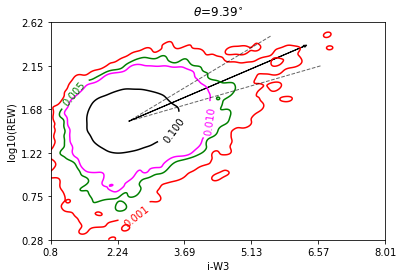

In [35]:
fig = plt.figure()
plt.clf()
plt.cla()
# den_plt=plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='coolwarm')
zi=zi/max(zi)
den_plt=plt.contour(xi, yi, zi.reshape(xi.shape), [0.001, 0.005, 0.01, 0.1], colors=['red', 'green', 'magenta', 'black'])
plt.clabel(den_plt, inline=1, fontsize=10)

# cbar= plt.colorbar(den_plt)
# cbar.set_label(r'$\rho$')
ax = fig.add_subplot(111)

plt.plot([(xf_cone[-1]-x0)*0.92+x0, x0], [(yf_cone[-1]-y0)*0.92+y0, y0], ls='--', lw=1, c='black' ,alpha=0.6)
plt.plot([xf_cone[0], x0], [yf_cone[0], y0], ls='--', 
        lw=1, c='black', alpha=0.6 )
plt.arrow(x0, y0, xf_cone[int(nCone*0.5)]-x0, yf_cone[int(0.5*nCone)]-y0,
        head_width=0.01, head_length=0.01, fc='black', ec='black')
ticks_x = ticker.FuncFormatter(lambda x, 
                                pos: '{0:g}'.format(round(x*rangeData[0]+ minData[0], 2)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_y = ticker.FuncFormatter(lambda x, 
                                pos: '{0:g}'.format(round(x*rangeData[1]+minData[1],2)))
ax.yaxis.set_major_formatter(ticks_y)
plt.xlabel('i-W3')
plt.ylabel('log10(REW)')

plt.title(r'$\theta$=%.2f$^{\circ}$' %(np.rad2deg(opening_angle)))
plt.savefig('Figs/kde-cmap.png', dpi=200, 
            bbox_inches='tight', format='png')

In [ ]:
#  Making 1D density prifile along the ERQ wedge 
line_segments=100; ex=1.3; nBootStrap=100
x_line = np.zeros([nCone, line_segments])
y_line = np.zeros([nCone, line_segments])
for i in range(nCone):
    x_line[i,:] =np.linspace(x0,xf_cone[i], line_segments) # x positions along a line as long as ERQ radius times the expansion which we calculate density 
    y_line[i,:] = np.linspace(y0,yf_cone[i], line_segments) # y positions ...
r = np.sqrt((x_line-x0)**2+(y_line-y0)**2) # radius of each point needed for density 

print(np.rad2deg(d_theta)*2)
den_ens = []

for ensemble in tqdm(range(nBootStrap)):
    test_ind = np.random.choice(range(len(data)), len(data), replace=True)
    
    data_boot = data[test_ind,:]
    kde =gaussian_kde(data_boot.T)
    kde.set_bandwidth(bw)
    den_con=[]
#         
    for i in (range(nCone)):
        line = np.array(list(zip(x_line[i,:], y_line[i,:])))
        density= kde(line.T)
        den_con.append(density) 
        #density for each point along a line stored in a row of density_cone

    d = np.median(den_con, axis=0)
    den_ens.append(d)
    # median of each column gives the median density for a secific radius from center 

den_FLUC = np.std(den_ens, axis=0)

#  Full sample density
kde =gaussian_kde(data.T)
kde.set_bandwidth(bw)
den_con=[]
den_max = max(kde(data.T))

for i in tqdm(range(nCone)):
    line = np.array(list(zip(x_line[i,:], y_line[i,:])))
    density= kde(line.T)
    den_con.append(density) #density for each point along a line stored in a row of density_cone
den_med = np.median(den_con, axis=0) # median of each column gives the median density for a secific radius from center 
den_ens0= np.array(den_ens)

In [ ]:
for i in range(len(den_ens)):
    plt.semilogy(r[0,:]/r_erq, den_ens[i][:], alpha=.4, lw=.2, c='gray')

plt.semilogy(r[0,:]/r_erq, den_med, alpha=1, lw=2, c='r')
        
plt.xlabel(r'r/r$_{CERQ}$')
plt.ylabel(r'$\rho$')
plt.title(r'$\theta = %.2f^{\circ}$'  %(np.rad2deg(opening_angle)))
plt.savefig('Figs/non-normalized-nB-%d-cone-2d-density-bw%2d-FLUC.png' %(nBootStrap, bw*100), bbox_inches='tight', format='png', dpi=200)
plt.show()
